In [1]:
!date

Thu Jan 12 12:24:22 PST 2023


In [2]:
!echo $CONDA_PREFIX

/c4/home/derek/miniconda3/envs/scquint


In [3]:
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
from scquint.data import load_adata_from_starsolo, add_gene_annotation, group_introns

from scquint.data import calculate_PSI

In [5]:
adata_SLR = sc.read_h5ad('/c4/home/derek/data1/derek/data_scSLR/PBMC/spl_3prime_splice_acceptor.h5ad')

In [9]:
adata_SS3 = sc.read_h5ad('/c4/home/derek/data1/derek/data_scSLR/reference/SS3_PBMC/SS3_PBMC_spl_3prime_splice_acceptor.h5ad')

In [7]:
# Here's a scatter plot of mean PSI where each point corresponds to an intron,cell_type pair, and the x-axis could be mean PSI in 
# SMARTseq and y-axis in SLR. The introns are those appear in both SMARTseq and SLR data. To make sure the mean of PSI are representative, we only
# plot the introns with PSI is defined in more than n=10 cells of thecell cluster. The Pearson correlation here is 0.926. This shows that for matched introns in both datasets, 
# mean PSIs of intron in each cell type cluster in one dataset are al so highly correlated with another.

In [17]:
adata_SLR.layers["PSI_raw"] = calculate_PSI(adata_SLR)

adata_SS3.layers["PSI_raw"] = calculate_PSI(adata_SS3)


/c4/home/derek/miniconda3/envs/scquint/lib/python3.10/site-packages/scquint/data.py:203: RuntimeWarning: invalid value encountered in divide
  return X / intron_group_sums[:,groups]


In [ ]:
##rename SS3 celltype annotations

In [29]:
adata_SS3 = adata_SS3[~adata_SS3.obs.celltype.isin(['HEK','HEK cells'])]

In [32]:
celltype_dict ={'CD14 monocytes':'cM',
 'Cytotoxic T':'T8',
 'Cytotoxic T cells':'T8',
 'Dendritic cells':'cDC',
 'Effector CD4 T':'T4',
 'FCGR3A NK cells':'NK',
 'FCGR3A monocytes':'ncM',
 'Memory B':'B',
 'NK cells':'NK',   
 'Naive B':'B',
 'Naive/Memory CD4 T':'T4',
 'Naive/Memory CD8 T':'T8',
 'Plasma cells':'PB',
 'Senescent CD4 T':'T4',
 'plasmacytoid DC':'pDC'
}

In [42]:
adata_SS3.obs['ct1'] = adata_SS3.obs.celltype.map(celltype_dict)

/scratch/derek/ipykernel_5107/2806265984.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_SS3.obs['ct1'] = adata_SS3.obs.celltype.map(celltype_dict)


In [35]:
marker_genes = adata_SLR.var.index.intersection(adata_SS3.var.index).tolist()

genedf_SLR = sc.get.obs_df(
        adata_SLR,
        keys=["ct1", *marker_genes],
    layer='PSI_raw'
)
    
    


In [44]:
adata_SS3.obs

,celltype,ct1
AACGTGACAAAACTGACCAA,Naive/Memory CD4 T,T4
AACGTGACAAACCGATTAGA,Naive/Memory CD4 T,T4
AACGTGACAAAGTCTAGAGA,Effector CD4 T,T4
AACGTGACAACCTCCTAGGT,NK cells,NK
AACGTGACAACGATTACGTA,CD14 monocytes,cM
...,...,...
TTGTTACTCCGTAGGTACAA,FCGR3A monocytes,ncM
TTGTTACTCCGTCCTTGGTG,Cytotoxic T,T8
TTGTTACTCCTAACGGATGA,Cytotoxic T cells,T8
TTGTTACTCCTACCAGTCCA,Memory B,B


In [37]:
df_SLR=pd.Series()

for celltype in genedf_SLR.ct1.unique():
    
    genedf_SLR_ = genedf_SLR[genedf_SLR.ct1 == celltype]
    
    genedf_SLR_.dropna(thresh = 10,
                 axis=1,inplace=True)

    means = genedf_SLR_.mean(axis=0)
    
   # means.name = celltype
    means.index = means.index.astype(str) + '_' + celltype
    
    df_SLR = df_SLR.append(means,
                  # ignore_index=True
                  )
    

/scratch/derek/ipykernel_5107/2835219013.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_SLR=pd.Series()
/scratch/derek/ipykernel_5107/2835219013.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genedf_SLR_.dropna(thresh = 10,
/scratch/derek/ipykernel_5107/2835219013.py:10: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  means = genedf_SLR_.mean(axis=0)
/scratch/derek/ipykernel_5107/2835219013.py:15: FutureWarning: The series.append method is deprecate

In [45]:
marker_genes = adata_SLR.var.index.intersection(adata_SS3.var.index).tolist()

genedf_SS3 = sc.get.obs_df(
        adata_SS3,
        keys=["ct1", *marker_genes],
    layer='PSI_raw'
)

In [46]:
df_SS3=pd.Series()

for celltype in genedf_SS3.ct1.unique():
    
    genedf_SS3_ = genedf_SS3[genedf_SS3.ct1 == celltype]
    
    genedf_SS3_.dropna(thresh = 10,
                 axis=1,inplace=True)

    means = genedf_SS3_.mean(axis=0)
    
    #means.name = celltype
    means.index = means.index.astype(str) + '_' + celltype
    
    df_SS3 = df_SS3.append(means,
                  # ignore_index=True
                  )
    

/scratch/derek/ipykernel_5107/1143787035.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_SS3=pd.Series()
/scratch/derek/ipykernel_5107/1143787035.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genedf_SS3_.dropna(thresh = 10,
/scratch/derek/ipykernel_5107/1143787035.py:10: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  means = genedf_SS3_.mean(axis=0)
/scratch/derek/ipykernel_5107/1143787035.py:15: FutureWarning: The series.append method is deprecate

In [47]:
df_SS3 = df_SS3[df_SS3.index.isin(df_SLR.index)]

In [48]:
df_SLR = df_SLR[df_SLR.index.isin(df_SS3.index)]

In [70]:
corr = df_SLR.corr(df_SS3,method = 'pearson')

In [52]:
df_SS3

RER1_chr1:2391959-2395783_T4          0.726644
RER1_chr1:2393356-2395783_T4          0.273356
CAMTA1_chr1:6785576-6825091_T4        0.264611
CAMTA1_chr1:6820251-6825091_T4        0.735389
PARK7_chr1:7961736-7962762_T4         0.614699
                                        ...   
RPL12_chr9:127450805-127451280_pDC    0.985714
RPL10_chrX:154398395-154398496_pDC    1.000000
RPL10_chrX:154398399-154398496_pDC    0.000000
RPL10_chrX:154399942-154400701_pDC    0.000614
RPL10_chrX:154400627-154400701_pDC    0.999386
Length: 9028, dtype: float64

In [53]:
df_SLR

RER1_chr1:2391959-2395783_T8          0.906250
RER1_chr1:2393356-2395783_T8          0.093750
CAMTA1_chr1:6785576-6825091_T8        0.312500
CAMTA1_chr1:6820251-6825091_T8        0.687500
PARK7_chr1:7961736-7962762_T8         0.578215
                                        ...   
RPL12_chr9:127450805-127451280_pDC    0.990530
RPL10_chrX:154398395-154398496_pDC    0.982185
RPL10_chrX:154398399-154398496_pDC    0.017815
RPL10_chrX:154399942-154400701_pDC    0.011719
RPL10_chrX:154400627-154400701_pDC    0.988281
Length: 9028, dtype: float64

Text(0, 0.5, 'Ψ scSLR-seq')

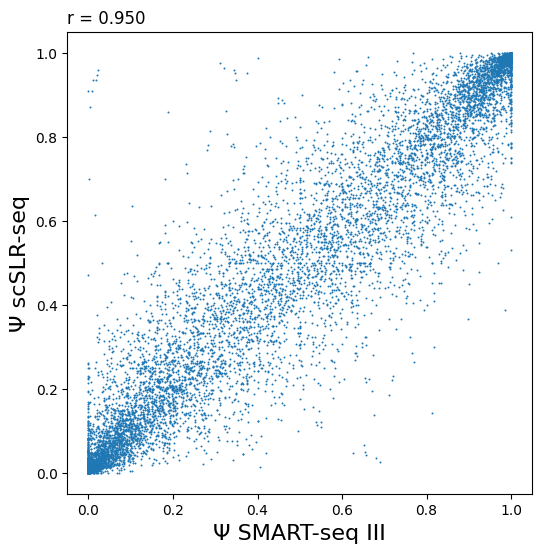

In [59]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(x=df_SS3,
                y=df_SLR,
                s=2,
                linewidth=0,
                ax=ax
                
               )

# ax.spines.right.set_visible(False)
# ax.spines.top.set_visible(False)

ax.set_title('r = 0.950',loc='left')

ax.set_xlabel('Ψ SMART-seq III', fontsize=16)
ax.set_ylabel('Ψ scSLR-seq', fontsize=16)



# sns.kdeplot(
#     data=tips,
#     x=df_SS3,
#     y=df,
#     levels=10,
#     fill=True,
#     alpha=1,#0.6,
#     cut=0,
#     ax=ax,
#    # clip
# )

In [56]:
data = pd.concat([df_SS3,df_SLR],axis=1)

In [57]:
data.columns = ['SS2','SLR']

Text(0.5, 0, 'Ψ scSLR-seq')

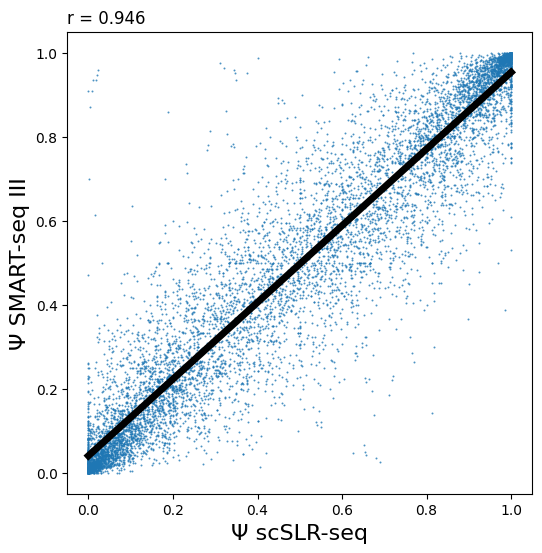

In [115]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.regplot(data = data,
            x='SS2',
            y='SLR',
            scatter_kws={'s':2, 'linewidth':0},
            line_kws={"lw":5, 'color':'black'},
            ax=ax
                
               )

# ax.spines.right.set_visible(False)
# ax.spines.top.set_visible(False)

ax.set_title(f'r = {round(corr,3)}',loc='left')

ax.set_ylabel('Ψ SMART-seq III', fontsize=16)
ax.set_xlabel('Ψ scSLR-seq', fontsize=16)



In [61]:
from scipy import stats

In [91]:
values = np.vstack([df_SS3, df_SLR])

In [110]:
kernel = stats.gaussian_kde(values)(values)

In [111]:
idx = kernel.argsort()
x, y, z = df_SLR[idx], df_SS3[idx], kernel[idx]

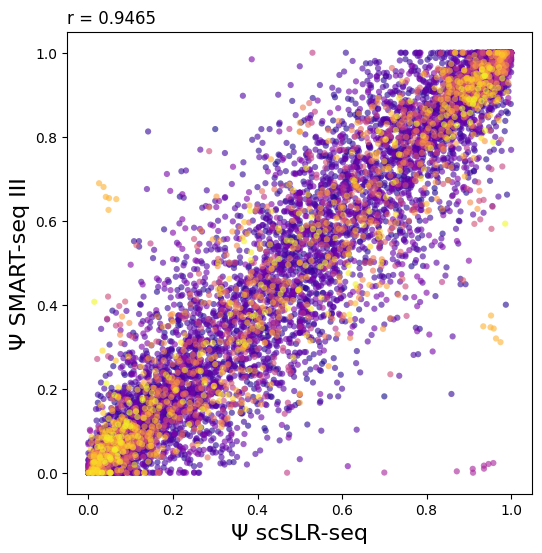

In [120]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(
    x=x,
    y=y,
    c=z,
    s=20,
    cmap="plasma",
    ax=ax,
    linewidth=0,
    alpha=.6
)

# ax.spines.right.set_visible(False)
# ax.spines.top.set_visible(False)

# ax.spines.bottom.set_linewidth(2)
# ax.spines.left.set_linewidth(2)


ax.set_title(f"r = {round(corr,4)}",loc='left')

ax.set_ylabel('Ψ SMART-seq III', fontsize=16)
ax.set_xlabel('Ψ scSLR-seq', fontsize=16)

fig.savefig('SLR_SS3_PBMC.pdf')

In [117]:
!conda list

# packages in environment at /c4/home/derek/miniconda3/envs/scquint:
#
# Name                    Version                   Build  Channel
_ipython_minor_entry_point 8.7.0                hb6b4a82_0    conda-forge
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
alsa-lib                  1.2.8                h166bdaf_0    conda-forge
anndata                   0.8.0              pyhd8ed1ab_1    conda-forge
anyio                     3.6.2              pyhd8ed1ab_0    conda-forge
appdirs                   1.4.4                    pypi_0    pypi
argcomplete               2.0.0                    pypi_0    pypi
argh                      0.26.2                   pypi_0    pypi
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py310h5764c6d_3    conda-forge
asciitree                 0.3.3                    pypi_0    pypi
asttokens    